# Analyse hydrogen market results from PyPSA-Earth network  

This notebook loads a solved PyPSA-Earth network (stored as a `.nc` file) and analyses the hydrogen market results.  
The code automatically searches the results folders 

- `results/<run_name>/networks/` for electricity-only runs  
- `<results_dir>/<sector_name>/postnetworks/` for sector-coupled runs 

Then opening the newest matching network file based on the scenario configuration in `config.yaml`.  

The notebook generates plots and summaries of key hydrogen metrics:  
* **Hydrogen Market Value**  
* **Hydrogen Production Cost**  
* **Hydrogen Capacity**  
* **Hydrogen Export**  


Sources: 
- locAL DEcarbonization and HYDrogen Export: https://github.com/energyLS/aldehyde 
- Statistics module: https://pypsa.readthedocs.io/en/latest/examples/statistics.html
- Templates and colors: https://github.com/pypsa-meets-earth/documentation/blob/main/notebooks/network_analysis.ipynb

File is needed:
* PyPSA network file (.nc) includes the hydrogen financing information.

## Import packages

In [21]:
import yaml
import pypsa
import warnings
import matplotlib.pyplot as plt
import os
import sys
import glob
import logging

## Settings

### Set project root

In [22]:
if not os.path.isdir("pypsa-earth"):
    os.chdir("../..")

PARENT = os.path.realpath("pypsa-earth") + os.sep

### Load configuration

In [23]:
with open(os.path.join(PARENT, "config.yaml"), "r") as f:
    cfg = yaml.safe_load(f)

run = cfg.get("run", {}) or {}
scen = cfg.get("scenario", {}) or {}
costs = cfg.get("costs", {}) or {}
expo = cfg.get("export", {}) or {}

results_dir = (cfg.get("results_dir", "results/") or "results/").strip("/") + "/"

### Directory definitions

In [24]:
RDIR = (run.get("name") or "").strip()
RDIR = (RDIR + "/") if RDIR else ""

SECDIR = (run.get("sector_name") or "").strip()
SECDIR = (SECDIR + "/") if SECDIR else ""

elec_dir = os.path.join(PARENT, results_dir, RDIR, "networks")
sector_post_dir = os.path.join(PARENT, results_dir, SECDIR, "postnetworks")
sector_pre_dir = os.path.join(PARENT, results_dir, SECDIR, "prenetworks")

### Wildcard helper

In [25]:
def pick(val, allow_empty=False):
    """
    Return single value if exactly one is given.
    Return '*' if multiple values or empty (unless allow_empty=True).
    """
    if val is None:
        return "*"
    if isinstance(val, (list, tuple)):
        if len(val) == 1:
            s = "" if val[0] is None else str(val[0])
            return s if (allow_empty or s != "") else "*"
        return "*"
    s = "" if val is None else str(val)
    return s if (allow_empty or s != "") else "*"

### Build wildcard segments

In [26]:
simpl = pick(scen.get("simpl", [""]), allow_empty=True)
clusters = pick(scen.get("clusters"))
ll = pick(scen.get("ll"))
opts = pick(scen.get("opts"))
sopts = pick(scen.get("sopts", [""]), allow_empty=True)
plan = pick(scen.get("planning_horizons"))
dr = pick(costs.get("discountrate"))
demand = pick(scen.get("demand"))

h2_raw = pick(expo.get("h2export"))
h2 = (h2_raw + "export") if h2_raw != "*" else "*export"

### Pattern builders

In [27]:
def post_pattern(include_sopts=True):
    core = f"elec_s{simpl}_{clusters}_ec_l{ll}_{opts}"
    tail = f"_{sopts}" if (include_sopts and sopts not in ("",)) else ""
    return os.path.join(sector_post_dir, f"{core}{tail}_{plan}_{dr}_{demand}_{h2}.nc")

def pre_patterns(include_sopts=True):
    core = f"elec_s{simpl}_{clusters}_ec_l{ll}_{opts}"
    tail = f"_{sopts}" if (include_sopts and sopts not in ("",)) else ""
    with_export = os.path.join(sector_pre_dir, f"{core}{tail}_{plan}_{dr}_{demand}_{h2}.nc")
    no_export = os.path.join(sector_pre_dir, f"{core}{tail}_{plan}_{dr}_{demand}.nc")
    return [with_export, no_export]

patterns = [
    post_pattern(include_sopts=True),
    post_pattern(include_sopts=False),
    *pre_patterns(include_sopts=True),
    *pre_patterns(include_sopts=False),
    os.path.join(elec_dir, f"elec_s{simpl}_{clusters}_ec_l{ll}_{opts}.nc"),
    os.path.join(elec_dir, f"elec_s{simpl}_{clusters}_ec_l{ll}_{opts}_*.nc"),
]

### Find networks

In [28]:
all_matches = []
for pat in patterns:
    all_matches.extend(glob.glob(pat))

# remove duplicates
all_matches = sorted(set(all_matches), key=os.path.getmtime)

if not all_matches:
    recent = sorted(
        glob.glob(os.path.join(PARENT, results_dir, "**", "*.nc"), recursive=True),
        key=os.path.getmtime
    )[-20:]
    recent_txt = "\n".join(os.path.relpath(p, PARENT) for p in recent) or "(none)"
    raise FileNotFoundError(
        "No network matched.\n"
        "Here are the last few .nc files under results/:\n"
        f"{recent_txt}"
    )

print("Found networks:")
for m in all_matches:
    print("-", os.path.relpath(m, PARENT))

Found networks:
- results/postnetworks/elec_s_10_ec_lc3.0_Co2L_3H_2035_0.071_AB_14export.nc


### Network Setup

In [29]:
logging.getLogger("pypsa.io").setLevel(logging.ERROR) # ignore warnings

chosen = all_matches[-1]  # choose newest one
print("\nOpening newest match:", os.path.relpath(chosen, PARENT), "\n")
n = pypsa.Network(chosen)
statistics = n.statistics()


Opening newest match: results/postnetworks/elec_s_10_ec_lc3.0_Co2L_3H_2035_0.071_AB_14export.nc 



## Analysis

### Hydrogen Market

In [30]:
# Hydrogen Market Value
h2_market = (statistics.loc["Link", "H2 Electrolysis"]["Market Value"]).round(2)
print(f"Yearly Hydrogen Market Value is: {h2_market} €")

Yearly Hydrogen Market Value is: 12.82 €


### Hydrogen Costs

In [31]:
h2_capex = (
        statistics.loc["Link", "H2 Electrolysis"]
        .loc["Capital Expenditure"]
        / 1e6
)  # in Mio. €
print(f"Capital Expenditure is: {h2_capex.round(2)} Mio. €")

h2_opex = (
    statistics.loc["Link", "H2 Electrolysis"]
    .loc["Operational Expenditure"]
    / 1e6
)  # in Mio. €
print(f"Operational Expenditure is: {h2_opex.round(2)} Mio. €")

hydrogen_production = (
    statistics.loc["Link", "H2 Electrolysis"]
    .loc["Supply"]
    .sum() 
    / 1e6
)  # in TWh

total_hydrogen_production_cost = h2_capex + h2_opex
hydrogen_cost_per_unit = total_hydrogen_production_cost / hydrogen_production

# Print Results
print(f"Total Hydrogen Production Cost: {total_hydrogen_production_cost.round(2)} Mio. €")
print(f"Hydrogen Production Cost per Unit: {hydrogen_cost_per_unit.round(2)} Mio. € per TWh")


Capital Expenditure is: 210.45 Mio. €
Operational Expenditure is: 0.22 Mio. €
Total Hydrogen Production Cost: 210.66 Mio. €
Hydrogen Production Cost per Unit: 12.82 Mio. € per TWh


### Hydrogen Exports

#### H2 Export on a hourly basis

<AxesSubplot:title={'center':'Hourly Hydrogen Export Prices'}, xlabel='Time', ylabel='Units: (€ / MWh)'>

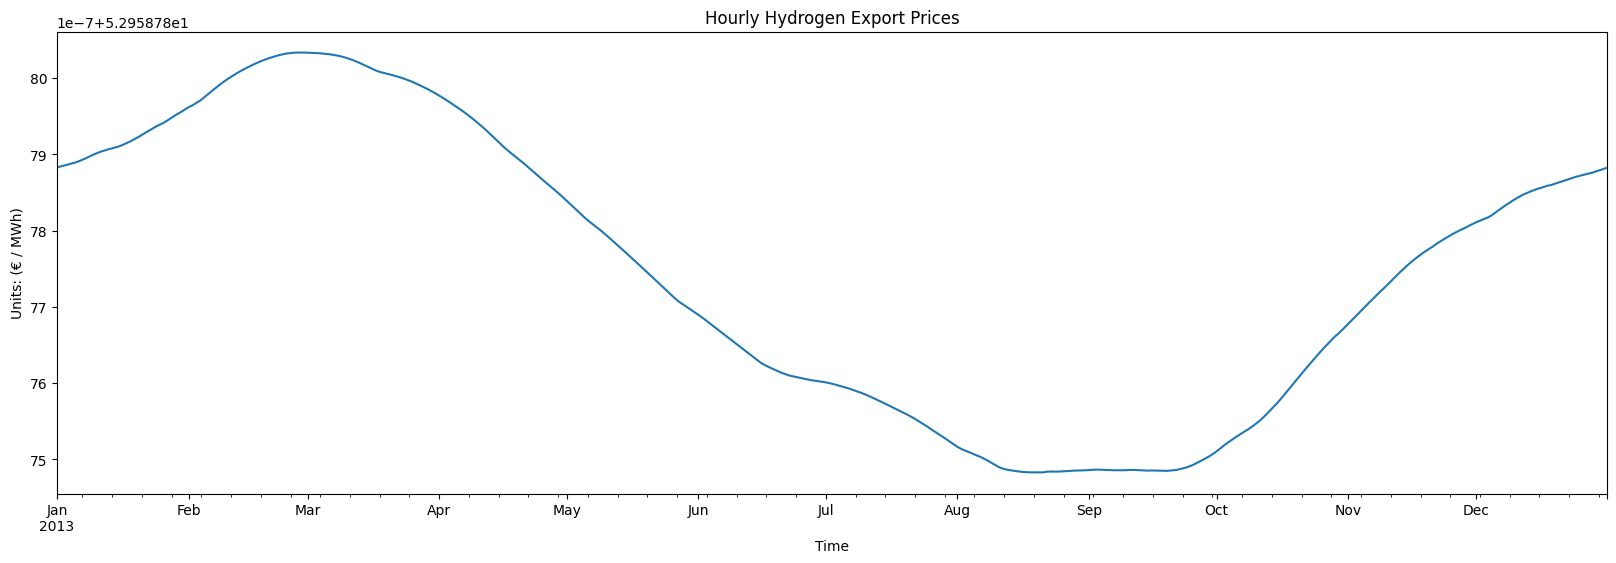

In [32]:
# Hourly hydrogen export prices
hydrogen_buses = n.buses[n.buses.index.str.contains("H2", case=False)]
hydrogen_prices = n.buses_t.marginal_price[hydrogen_buses.index]
hydrogen_export_prices = hydrogen_prices["H2 export bus"]
hydrogen_export_prices.plot(
    title="Hourly Hydrogen Export Prices",
    xlabel="Time",
    ylabel="Units: (€ / MWh)",
    figsize=(20, 6)
)

<AxesSubplot:title={'center':'Hourly Hydrogen Export Quantity'}, xlabel='Time', ylabel='Units: (MWh)'>

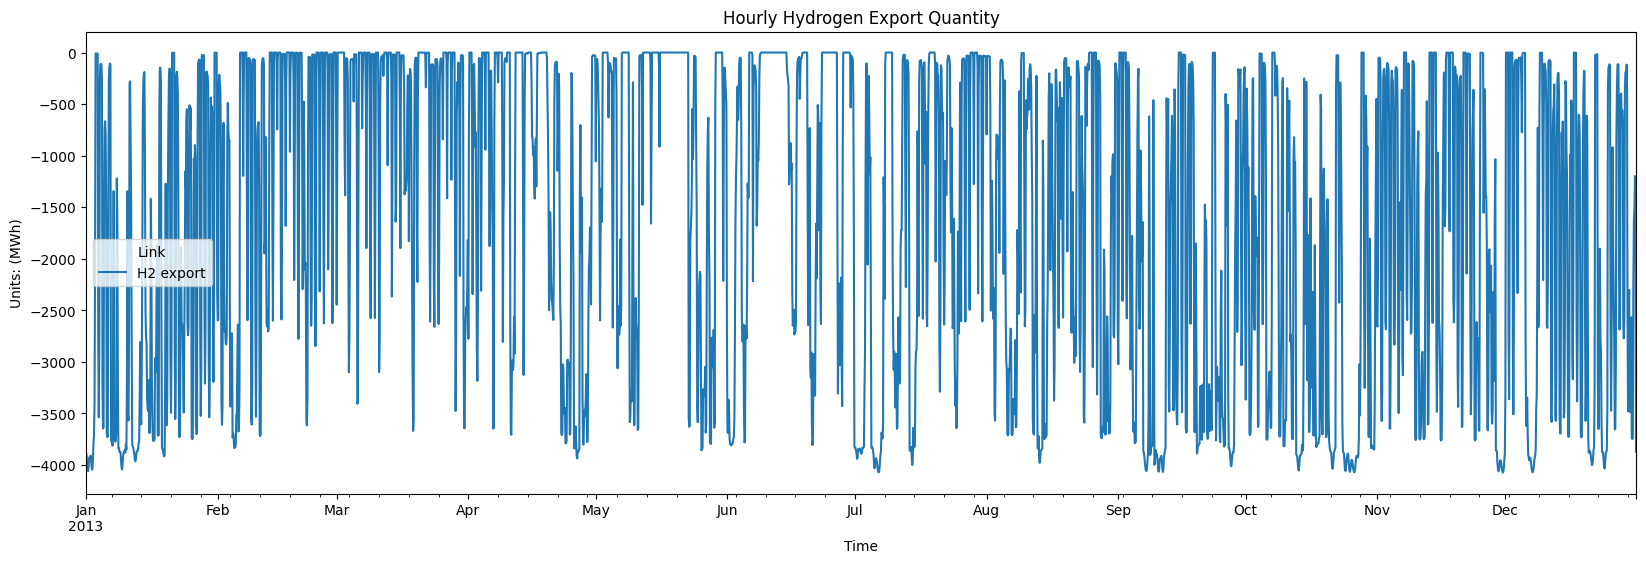

In [33]:
# Filter hydrogen export links and their quantities
hydrogen_export_links = n.links[n.links["carrier"] == "H2"]
hydrogen_export_quantity = n.links_t.p1[hydrogen_export_links.index]
hydrogen_export_quantity_cp = hydrogen_export_quantity.copy()
# Identify columns with export data dynamically (e.g., based on a naming pattern)
export_columns = [
    col for col in hydrogen_export_quantity_cp.columns if "H2 export" in col
]

# Sum the identified export columns into a new column named 'H2 export'
hydrogen_export_quantity_cp["H2 export"] = hydrogen_export_quantity_cp[export_columns].sum(axis=1)

# Drop the original separate export columns
hydrogen_export_quantity_cp = hydrogen_export_quantity_cp.drop(export_columns, axis=1)

# Plot the results
hydrogen_export_quantity_cp.plot(
    title="Hourly Hydrogen Export Quantity",
    xlabel="Time",
    ylabel="Units: (MWh)",
    figsize=(20, 6)
)

<AxesSubplot:title={'center':'Hourly Hydrogen Export Revenue'}, xlabel='Time', ylabel='Units: (€)'>

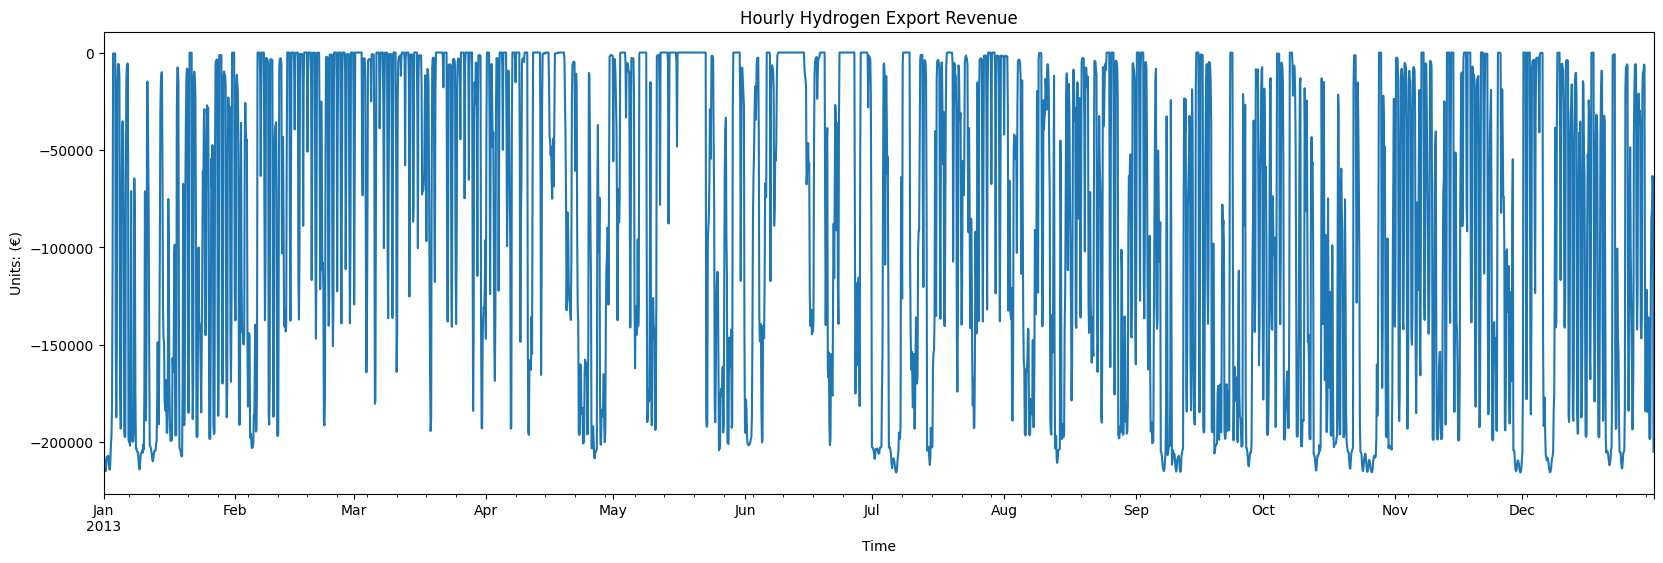

In [34]:
# Revenue
hydrogen_export_quantity.set_index(hydrogen_export_prices.index, inplace=True)
hydrogen_export_quantity_cp["Hourly Revenue"] = (
    hydrogen_export_quantity_cp["H2 export"] * hydrogen_export_prices
)

hydrogen_export_quantity_cp["Hourly Revenue"].plot(
    title="Hourly Hydrogen Export Revenue",
    xlabel="Time",
    ylabel="Units: (€)",
    figsize=(20, 6)
)

#### H2 Export on a yearly basis

In [35]:
H2_export_TWh = n.statistics.energy_balance(comps=["Load"]).loc[:,"H2"].values[0]/1e6 # in TWh
print(f"Yearly Hydrogen Export Quantity is: {H2_export_TWh} TWh")
H2_export_revenue = H2_export_TWh*h2_market
print(f"Hydrogen Export Revenue (yearly) is: {H2_export_revenue.round(2)} Mio. €")

Yearly Hydrogen Export Quantity is: -14.0 TWh
Hydrogen Export Revenue (yearly) is: -179.48 Mio. €


### Hydrogen Capacity

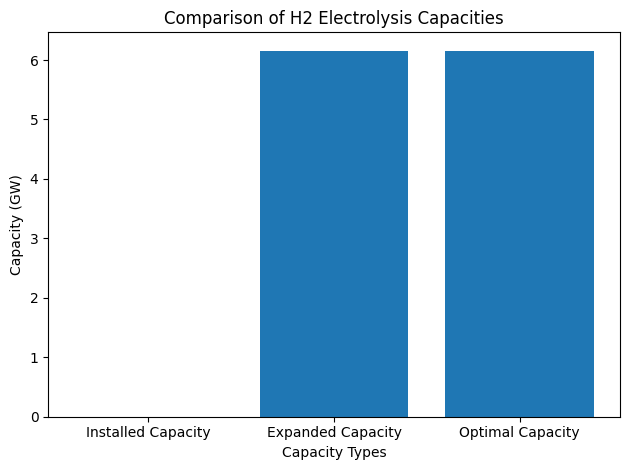

In [36]:
installed_capacity = n.statistics.installed_capacity(comps='Link').loc["H2 Electrolysis"]/ 1e3
expanded_capacity = n.statistics.expanded_capacity(comps='Link').loc["H2 Electrolysis"]/ 1e3
optimal_capacity = n.statistics.optimal_capacity(comps='Link').loc["H2 Electrolysis"]/ 1e3

categories = ['Installed Capacity', 'Expanded Capacity', 'Optimal Capacity']
values = [installed_capacity, expanded_capacity, optimal_capacity]

plt.figure()
plt.bar(categories, values)
plt.title('Comparison of H2 Electrolysis Capacities')
plt.ylabel('Capacity (GW)') 
plt.xlabel('Capacity Types')
plt.tight_layout()
plt.show()